<a href="https://colab.research.google.com/github/Haodong12/AIPI-590/blob/main/Assignment%209.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590 - XAI | Assignment #09

This assignment explores tutorial and demo for actvation patch with extended visual and markdown explainations.

Haodong He

 # Activation Patching in TransformerLens Demo
 This is an accompaniment to [Exploratory Analysis Demo](https://neelnanda.io/exploratory-analysis-demo). That notebook explains some basic techniques for mech interp of networks, including an overview of activation patching ([summary here](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qeWBvs-R-taFfcCq-S_hgMqx)). This demonstrates how to use the Activation Patching utils in TransformerLens.


 <b style="color: red">To use this notebook, go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.</b>

 **Tips for reading this Colab:**
 * You can run all this code for yourself!
 * The graphs are interactive!
 * Use the table of contents pane in the sidebar to navigate
 * Collapse irrelevant sections with the dropdown arrows
 * Search the page using the search in the sidebar, not CTRL+F

 ## Setup (Ignore)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/TransformerLensOrg/TransformerLens.git
    # Install my janky personal plotting utils
    %pip install git+https://github.com/neelnanda-io/neel-plotly.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/TransformerLensOrg/TransformerLens.git to /tmp/pip-req-build-n9u2eb8t
  Running command git clone --filter=blob:none --quiet https://github.com/TransformerLensOrg/TransformerLens.git /tmp/pip-req-build-n9u2eb8t
  Resolved https://github.com/TransformerLensOrg/TransformerLens.git to commit 8f482fc5e272b60b30924136f437f3676791f96c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:0

In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio

if IN_COLAB or not DEBUG_MODE:
    # Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "png"

In [3]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [4]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

 We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [5]:
torch.set_grad_enabled(False)

 Plotting helper functions from a janky personal library of plotting utils. The library is not documented and I recommend against trying to read it, just use your preferred plotting library if you want to do anything non-obvious:

In [6]:
from neel_plotly import line, imshow, scatter

In [7]:
import transformer_lens.patching as patching

 ## Activation Patching Setup
 This just copies the relevant set up from Exploratory Analysis Demo, and isn't very important.

In [8]:
model = HookedTransformer.from_pretrained("gpt2-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Loaded pretrained model gpt2-small into HookedTransformer


This code initializes the GPT-2 small model using the HookedTransformer class from transformer_lens. This allows for examining and adjusting specific layers or points in the model to apply activation patching techniques.

In [9]:
prompts = ['When John and Mary went to the shops, John gave the bag to', 'When John and Mary went to the shops, Mary gave the bag to', 'When Tom and James went to the park, James gave the ball to', 'When Tom and James went to the park, Tom gave the ball to', 'When Dan and Sid went to the shops, Sid gave an apple to', 'When Dan and Sid went to the shops, Dan gave an apple to', 'After Martin and Amy went to the park, Amy gave a drink to', 'After Martin and Amy went to the park, Martin gave a drink to']
answers = [(' Mary', ' John'), (' John', ' Mary'), (' Tom', ' James'), (' James', ' Tom'), (' Dan', ' Sid'), (' Sid', ' Dan'), (' Martin', ' Amy'), (' Amy', ' Martin')]

clean_tokens = model.to_tokens(prompts)
# Swap each adjacent pair, with a hacky list comprehension
corrupted_tokens = clean_tokens[
    [(i+1 if i%2==0 else i-1) for i in range(len(clean_tokens)) ]
    ]
print("Clean string 0", model.to_string(clean_tokens[0]))
print("Corrupted string 0", model.to_string(corrupted_tokens[0]))

answer_token_indices = torch.tensor([[model.to_single_token(answers[i][j]) for j in range(2)] for i in range(len(answers))], device=model.cfg.device)
print("Answer token indices", answer_token_indices)

Clean string 0 <|endoftext|>When John and Mary went to the shops, John gave the bag to
Corrupted string 0 <|endoftext|>When John and Mary went to the shops, Mary gave the bag to
Answer token indices tensor([[ 5335,  1757],
        [ 1757,  5335],
        [ 4186,  3700],
        [ 3700,  4186],
        [ 6035, 15686],
        [15686,  6035],
        [ 5780, 14235],
        [14235,  5780]], device='cuda:0')


Prompts are defined, and tokenized versions are created for both clean and corrupted scenarios, with corruption achieved by swapping token sequences.

In [10]:
def get_logit_diff(logits, answer_token_indices=answer_token_indices):
    if len(logits.shape)==3:
        # Get final logits only
        logits = logits[:, -1, :]
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

Clean logit diff: 3.5519
Corrupted logit diff: -3.5519


This function calculates the difference in logits for correct vs. incorrect tokens to create a baseline for comparison. The model runs on both clean and corrupted tokens, storing logits and activations in clean_cache and corrupted_cache.

In [11]:
CLEAN_BASELINE = clean_logit_diff
CORRUPTED_BASELINE = corrupted_logit_diff
def ioi_metric(logits, answer_token_indices=answer_token_indices):
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (CLEAN_BASELINE  - CORRUPTED_BASELINE)

print(f"Clean Baseline is 1: {ioi_metric(clean_logits).item():.4f}")
print(f"Corrupted Baseline is 0: {ioi_metric(corrupted_logits).item():.4f}")

Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000


 ## Patching
 In the following cells, we use the patching module to call activation patching utilities

In [12]:
# Whether to do the runs by head and by position, which are much slower
DO_SLOW_RUNS = True

 ### Patching Single Activation Types
 We start by patching single types of activation
 The general syntax is that the functions are called get_act_patch_... and take in (model, corrupted_tokens, clean_cache, patching_metric)

 We can patch the residual stream at the start of each block over each layer and position
 resid_pre -> attn_out, mlp_out, resid_mid all also work

In [13]:
resid_pre_act_patch_results = patching.get_act_patch_resid_pre(model, corrupted_tokens, clean_cache, ioi_metric)

  0%|          | 0/180 [00:00<?, ?it/s]

In [14]:
imshow(resid_pre_act_patch_results,
       yaxis="Layer",
       xaxis="Position",
       x=[f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))],
       title="resid_pre Activation Patching")

**Plot explaination:**

This plot visualizes the effect of activation patching on specific layers and positions in a language model (GPT-2) while performing a pronoun resolution task. The goal of this task is for the model to correctly predict the next word based on given prompts like:

"When John and Mary went to the shops, John gave the bag to..."
"When Dan and Sid went to the shops, Sid gave an apple to..."
For each prompt, we swap the pronouns (corrupting the input) to see how the model's behavior changes. We measure how much the activation patching can correct or influence the model’s output, especially focusing on the model's ability to associate the correct pronouns.

Color Scale:

Blue regions represent high positive influence, where activation patching has a strong corrective effect on the model’s output.
Red regions indicate negative influence.
Neutral colors (closer to white) suggest little or no effect from patching at that layer and position.

Interpretation of Results:
The blue areas, particularly around names like "John" or "Mary" in specific layers, show where activation patching has the most substantial impact. This implies that those tokens and layers play a critical role in the model’s understanding of who performed the action (e.g., "John gave the bag..."). By focusing on these regions, activation patching can correct the corrupted inputs to help the model predict the correct pronoun association.


 We can patch head outputs over each head in each layer, patching across all positions at once
 out -> q, k, v, pattern all also work

In [15]:
attn_head_out_all_pos_act_patch_results = patching.get_act_patch_attn_head_out_all_pos(model, corrupted_tokens, clean_cache, ioi_metric)

  0%|          | 0/144 [00:00<?, ?it/s]

In [16]:
imshow(attn_head_out_all_pos_act_patch_results,
       yaxis="Layer",
       xaxis="Head",
       title="attn_head_out Activation Patching (All Pos)")

This plot highlights which attention heads in specific layers are most affected by activation patching and thereby have the greatest impact on the model's performance:

Layers 2, 6, and 10 appear to be particularly important in this context, with specific heads (like heads 5, 6, and 8) in these layers showing strong influence.
Blue patches indicate heads that, when patched, increase confidence in correct answers, implying they are beneficial for accurate predictions.
Red patches suggest heads that, when altered, decrease confidence, indicating they may be crucial for the model’s understanding of the task and should remain unchanged for optimal performance.


 We can patch head outputs over each head in each layer, patching on each position in turn
 out -> q, k, v, pattern all also work, though note that pattern has output shape [layer, pos, head]
 We reshape it to plot nicely

In [17]:
ALL_HEAD_LABELS = [f"L{i}H{j}" for i in range(model.cfg.n_layers) for j in range(model.cfg.n_heads)]

In [18]:
if DO_SLOW_RUNS:
    attn_head_out_act_patch_results = patching.get_act_patch_attn_head_out_by_pos(model, corrupted_tokens, clean_cache, ioi_metric)
    attn_head_out_act_patch_results = einops.rearrange(attn_head_out_act_patch_results, "layer pos head -> (layer head) pos")

  0%|          | 0/2160 [00:00<?, ?it/s]

In [19]:
if DO_SLOW_RUNS and attn_head_out_act_patch_results is not None:
    imshow(attn_head_out_act_patch_results,
        yaxis="Head Label",
        xaxis="Pos",
        x=[f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))],
        y=ALL_HEAD_LABELS,
        title="attn_head_out Activation Patching By Pos")

This plot visualizes the impact of activation patching on the output of specific attention heads across different layers in the model. Here, we are using activation patching on the model's attention head outputs to understand how each head contributes to the model's interpretation of the input sequence.

Color Scale:

Blue indicates a positive impact, where activation patching for that head and position increases the model’s confidence in the correct prediction.
Red represents a negative impact, suggesting that patching at that head and position decreases confidence in the correct answer.
Lighter colors near zero suggest little or no influence from patching at that position and head.

Interpretation of Results:

The clusters of blue and red in specific rows (heads) and columns (positions) reveal which heads are most responsive to activation patching.
For instance, blue stripes near the tokens like "John" and "bag" suggest that specific heads in certain layers play a significant role in resolving who gave the bag to whom.
Heads with stronger blue or red signals likely have a significant role in maintaining or altering the correct answer after patching, indicating that these heads are crucial for the model’s understanding of pronoun resolution.

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch

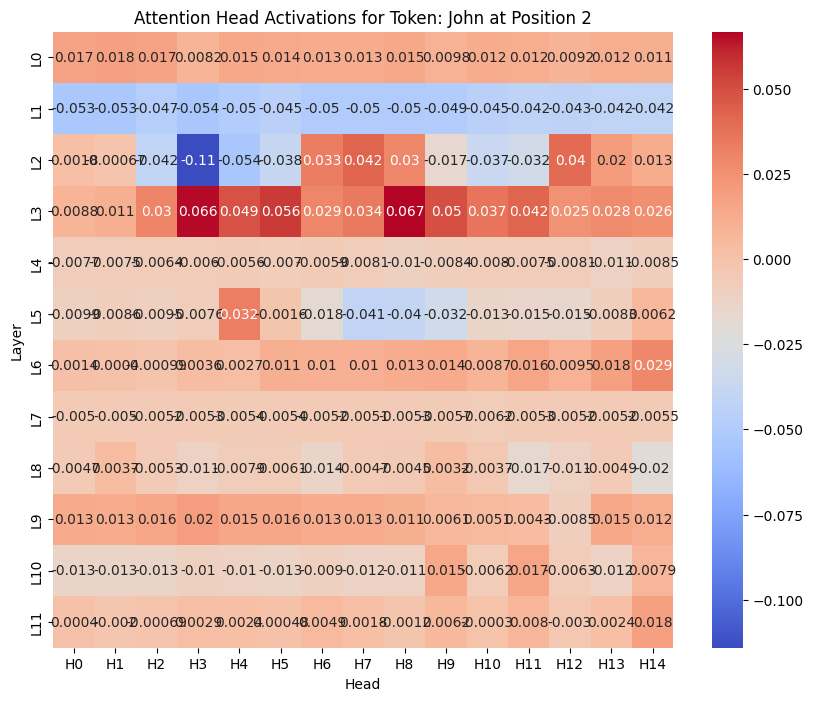

In [21]:
def plot_attention_head_heatmap(cache, token_position, token_name):
    """
    Plots a heatmap of attention head activations for a specified token position.

    Parameters:
    cache (dict): Cached activations from model.run_with_cache.
    token_position (int): The position of the token in the input sequence.
    token_name (str): The name of the token being analyzed, used for the plot title.
    """
    # Initialize an empty list to collect activations
    activations_list = []

    # Get the number of layers based on keys in the cache
    available_layers = [key for key in cache if "attn.hook_z" in key]
    n_layers = len(available_layers)

    # Loop through each layer to extract activations for all heads at the given token position
    for layer in range(n_layers):
        # Extract the activation tensor for the given layer and token position across all heads
        layer_key = f'blocks.{layer}.attn.hook_z'
        if layer_key in cache:
            layer_activations = cache[layer_key][:, :, token_position]

            # If batch dimension is present, take the mean across the batch
            if layer_activations.dim() == 3:
                layer_activations = layer_activations.mean(dim=0)  # Average across the batch dimension

            # Append the activations to the list (convert to numpy if needed for plotting)
            activations_list.append(layer_activations.mean(dim=-1).cpu().detach().numpy())
        else:
            print(f"Layer {layer} not found in cache.")
            break

    # Stack the list into a 2D numpy array for plotting
    activations = np.stack(activations_list)

    # Plot the heatmap with detected number of heads
    plt.figure(figsize=(10, 8))
    sns.heatmap(activations, annot=True, cmap="coolwarm", cbar=True,
                xticklabels=[f"H{i}" for i in range(activations.shape[1])],
                yticklabels=[f"L{i}" for i in range(len(activations_list))])

    plt.title(f"Attention Head Activations for Token: {token_name} at Position {token_position}")
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.show()


token_position = 2
token_name = "John"

# Call the heatmap function
plot_attention_head_heatmap(clean_cache, token_position, token_name)


 ### Patching multiple activation types
 Some utilities are provided to patch multiple activations types *in turn*. Note that this is *not* a utility to patch multiple activations at once, it's just a useful scan to get a sense for what's going on in a model
 By block: We patch the residual stream at the start of each block, attention output and MLP output over each layer and position

In [22]:
every_block_result = patching.get_act_patch_block_every(model, corrupted_tokens, clean_cache, ioi_metric)

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

In [23]:
imshow(every_block_result, facet_col=0, facet_labels=["Residual Stream", "Attn Output", "MLP Output"], title="Activation Patching Per Block", xaxis="Position", yaxis="Layer", zmax=1, zmin=-1, x= [f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))])

This plot helps us understand which parts of each layer are most important for this task:

The Residual Stream has the most significant impact, suggesting that information flowing through this pathway is crucial for the model’s understanding of relationships between tokens.
The Attn Output has some effect, especially in lower layers, though it is less pronounced.
The MLP Output shows that specific layers (e.g., layers 0 and 6) play some role, but overall, the effect is moderate.

 By head: For each head we patch the output, query, key, value or pattern. We do all positions at once so it's not super slow.

In [24]:
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(model, corrupted_tokens, clean_cache, ioi_metric)

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

In [25]:
imshow(every_head_all_pos_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head (All Pos)", xaxis="Head", yaxis="Layer", zmax=1, zmin=-1)

Interpretation of Each Component
Output:

The Output component shows moderate activations in various heads across layers, indicating that certain heads in these layers contribute significantly to the model's understanding of the task.
Some notable activations are seen in heads 5, 8, and 10 in layers 4, 6, and 10, suggesting that these heads play an important role in processing the information needed to resolve relationships between tokens.
Query:

The Query component has lighter activations overall, with some blue and red areas indicating the effect of activation patching on this component is weaker compared to Output.
This suggests that the Query part of the attention heads may be less influential on the model’s performance for this specific task but still plays a role in certain heads and layers, such as in heads 5 and 10 of layers 4 and 10.
Key:

The Key component shows sparse activation patches, with only a few heads and layers exhibiting notable effects.
This suggests that the Key part of the attention mechanism is not highly sensitive to activation patching in this context, but specific heads (e.g., in layer 6) still have some effect.
Value:

The Value component shows moderate activations, with a pattern similar to Output but somewhat weaker.
This indicates that certain heads in the Value component are important for storing information, which is then used in conjunction with Query and Key to influence the output.
Pattern:

The Pattern component shows a mix of blue and red areas, particularly in layers 4, 6, and 10, suggesting it has some influence in specific heads.
This component may represent the learned attention patterns that capture relationships between tokens. The observed activations imply that certain heads capture patterns critical for this task.


In [26]:
if DO_SLOW_RUNS:
    every_head_act_patch_result = patching.get_act_patch_attn_head_by_pos_every(model, corrupted_tokens, clean_cache, ioi_metric)
    every_head_act_patch_result = einops.rearrange(every_head_act_patch_result, "act_type layer pos head -> act_type (layer head) pos")

  0%|          | 0/2160 [00:00<?, ?it/s]

  0%|          | 0/2160 [00:00<?, ?it/s]

  0%|          | 0/2160 [00:00<?, ?it/s]

  0%|          | 0/2160 [00:00<?, ?it/s]

  0%|          | 0/2160 [00:00<?, ?it/s]

In [27]:
if DO_SLOW_RUNS and every_head_act_patch_result is not None:
    imshow(every_head_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head (By Pos)", xaxis="Position", yaxis="Layer & Head", zmax=1, zmin=-1, x= [f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))], y=ALL_HEAD_LABELS)

Interpretation of Each Component
Output:

There is notable blue and red activation in heads across specific layers, particularly near tokens like "John" and "bag."
This suggests that the Output component of specific heads is crucial for processing and maintaining the relationships needed for the model's understanding of the task.
Query:

Some patches in the Query component show an effect in specific layers and heads, though the influence is generally weaker than in Output.
This indicates that while the Query component plays a role in understanding relationships, its influence is not as strong in this context.
Key:

Minimal patches are visible in the Key component, indicating that it is less sensitive to activation patching for this particular task.
This implies that the model is not as dependent on the Key values when resolving the relationships in the sentence.
Value:

Value shows a moderate level of influence, similar to Output, especially for certain heads in layers 4, 8, and 10.
This suggests that the Value component is somewhat important in encoding the relevant information needed by the model.
Pattern:

There is a mixed effect in Pattern, with some red and blue areas spread across different heads and positions.
This component may be capturing generalizable patterns that affect model behavior, but its influence is less pronounced than Output and Value.

 ## Induction Patching
 To show how easy it is, lets do that again with induction heads in a 2L Attention Only model
 The input will be repeated random tokens eg BOS 1 5 8 9 2 1 5 8 9 2, and we judge the model's ability to predict the second repetition with its induction heads
 Lets call A, B and C different (non-repeated) random sequences. We'll start with clean tokens AA and corrupted tokens AB, and see how well the model can predict the second A given the first A

 ### Setup

We start by setting up the model and generating random token sequences. The input sequence will consist of random tokens repeated in a specific pattern. We aim to test the model’s capacity to predict the second instance of each repeated token pattern.

In [28]:
attn_only = HookedTransformer.from_pretrained("attn-only-2l")
batch = 4
seq_len = 20
rand_tokens_A = torch.randint(100, 10000, (batch, seq_len)).to(attn_only.cfg.device)
rand_tokens_B = torch.randint(100, 10000, (batch, seq_len)).to(attn_only.cfg.device)
rand_tokens_C = torch.randint(100, 10000, (batch, seq_len)).to(attn_only.cfg.device)
bos = torch.tensor([attn_only.tokenizer.bos_token_id]*batch)[:, None].to(attn_only.cfg.device)
clean_tokens_induction = torch.cat([bos, rand_tokens_A, rand_tokens_A], dim=1).to(attn_only.cfg.device)
corrupted_tokens_induction = torch.cat([bos, rand_tokens_A, rand_tokens_B], dim=1).to(attn_only.cfg.device)

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model_final.pth:   0%|          | 0.00/210M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.04M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Loaded pretrained model attn-only-2l into HookedTransformer


Next, we run the model with both the clean and corrupted token sequences, caching the activations for further analysis. By caching the activations, we can analyze the effects of specific layers and attention heads without re-running the model multiple times, which saves computation.

In [29]:
clean_logits_induction, clean_cache_induction = attn_only.run_with_cache(clean_tokens_induction)
corrupted_logits_induction, corrupted_cache_induction = attn_only.run_with_cache(corrupted_tokens_induction)

We define a custom loss function, induction_loss, to evaluate the model’s performance. This metric is calculated as the negative log probability of predicting the second half of the repeated sequence correctly. Higher values indicate better performance.

In [30]:
def induction_loss(logits, answer_token_indices=rand_tokens_A):
    seq_len = answer_token_indices.shape[1]

    # logits: batch x seq_len x vocab_size
    # Take the logits for the answers, cut off the final element to get the predictions for all but the first element of the answers (which can't be predicted)
    final_logits = logits[:, -seq_len:-1]
    final_log_probs = final_logits.log_softmax(-1)
    return final_log_probs.gather(-1, answer_token_indices[:, 1:].unsqueeze(-1)).mean()
CLEAN_BASELINE_INDUCTION = induction_loss(clean_logits_induction).item()
print("Clean baseline:", CLEAN_BASELINE_INDUCTION)
CORRUPTED_BASELINE_INDUCTION = induction_loss(corrupted_logits_induction).item()
print("Corrupted baseline:", CORRUPTED_BASELINE_INDUCTION)

Clean baseline: -1.978823184967041
Corrupted baseline: -11.864673614501953


 ### Patching

In [31]:
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(attn_only, corrupted_tokens_induction, clean_cache_induction, induction_loss)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [32]:
imshow(every_head_all_pos_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head (All Pos)", xaxis="Head", yaxis="Layer", zmax=CLEAN_BASELINE_INDUCTION)

Color Scale: The color scale ranges from blue to red, with blue indicating positive effects (increased confidence in correct predictions) and red indicating negative effects (decreased confidence).
Observation: We can see that some heads have a more significant effect on the model's performance than others. For example, in the Output and Value components, certain heads are more activated, suggesting their importance in maintaining the model's accuracy.


In [33]:
if DO_SLOW_RUNS:
    every_head_act_patch_result = patching.get_act_patch_attn_head_by_pos_every(
        attn_only, corrupted_tokens_induction, clean_cache_induction, induction_loss
    )

    every_head_act_patch_result = einops.rearrange(
        every_head_act_patch_result, "act_type layer pos head -> act_type (layer head) pos"
    )

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

In [34]:
if DO_SLOW_RUNS and every_head_act_patch_result is not None:
    imshow(
        every_head_act_patch_result,
        facet_col=0,
        facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
        title="Activation Patching Per Head (By Pos)",
        xaxis="Position",
        yaxis="Layer & Head",
        zmax=CLEAN_BASELINE_INDUCTION,
        x=[f"{tok}_{i}" for i, tok in enumerate(attn_only.to_str_tokens(clean_tokens_induction[0]))],
        y=[f"L{l}H{h}" for l in range(attn_only.cfg.n_layers) for h in range(attn_only.cfg.n_heads)]
    )

Axes:
Layer & Head (Y-axis): Combines layers and heads, showing the specific heads within each layer.
Position (X-axis): Represents token positions within the input sequence, labeled by tokens.
Color Scale: The color scale reflects the degree of influence each component at each position has, with blue indicating a positive effect and red indicating a negative effect.
Observation: Certain heads at specific positions show strong blue or red, meaning they play an essential role in understanding specific tokens within the sequence. This analysis can help determine which parts of the model are critical for processing certain tokens or maintaining pattern consistency.

 ### Changing the Corrupted Baseline
 We can also change the corrupted baseline easily to check what things look like! We'll keep clean as AA, but rather than corrupted as AB, we'll try out:
 * BA - This has a corrupted first half, so we expect both keys *and* values to matter. Head output patching should work, but value and key and pattern won't.
 * BB - This is still inductiony but with different tokens. So keys, queries and patterns don't matter, head output patching will work, and value will.
 * BC - This is just random tokens, so everything is corrupted! The induction head needs queries, keys *and* values, so only output will work.

We define new token sequences (corrupted_tokens_induction_BA, corrupted_tokens_induction_BB, corrupted_tokens_induction_BC) based on the modified baselines described above.

In [35]:
corrupted_tokens_induction_BA = torch.cat([bos, rand_tokens_B, rand_tokens_A], dim=1).to(attn_only.cfg.device)
corrupted_tokens_induction_BB = torch.cat([bos, rand_tokens_B, rand_tokens_B], dim=1).to(attn_only.cfg.device)
corrupted_tokens_induction_BC = torch.cat([bos, rand_tokens_B, rand_tokens_C], dim=1).to(attn_only.cfg.device)

We proceed to compute the activation patching results for each of these corrupted baselines to observe how the model’s attention mechanism responds to different levels of corruption.

In [36]:
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(attn_only, corrupted_tokens_induction_BA, clean_cache_induction, induction_loss)
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(attn_only, corrupted_tokens_induction_BB, clean_cache_induction, induction_loss)
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(attn_only, corrupted_tokens_induction_BC, clean_cache_induction, induction_loss)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [37]:
imshow(every_head_all_pos_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head on BA (All Pos)", xaxis="Head", yaxis="Layer", zmax=CLEAN_BASELINE_INDUCTION)


Observations: The Output component shows some significant activations (in blue and red), especially around specific heads, indicating that this part might be compensating for the corrupted keys and values in the first half.

In [38]:
imshow(every_head_all_pos_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head on BB (All Pos)", xaxis="Head", yaxis="Layer", zmax=CLEAN_BASELINE_INDUCTION)


Observations: The Output and Value components have some localized activations, especially around specific heads. This suggests that while the query and pattern may not be useful, the output and values are still important for maintaining predictions under this structure.

In [39]:
imshow(every_head_all_pos_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head on BC (All Pos)", xaxis="Head", yaxis="Layer", zmax=CLEAN_BASELINE_INDUCTION)

The Output component again shows activations around particular heads, indicating that the model is attempting to handle the task primarily through its output mechanism due to the lack of any meaningful pattern in other components.